# 다람쥐, 쥐, 토끼의 COI 염기서열 144개 무작위 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들

In [2]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 30, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getOrganism(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    a = []
    for i in r.organism:
        if(i.isdigit() == True):
            break
        else:
            a.append(i)
    return ''.join(a[:-1])

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [3]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

516


### 기존 데이터 슬라이싱 후 3-mer 적용

In [4]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getOrganism(record.id)
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [5]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[2 4 2 4 7 4 2 8 5 7 4 2 5 5 5 8 8 8 8 8 8 8 8 8 8 8 4 4 8 8 8 4 4 8 1 1 4
 4 2 4 4 4 4 2 4 4 4 2 4 4 4 4 8 2 2 2 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 5 5 5
 5 5 7 8 8 7 8 1 7 4 4 4 4 4 4 4 4 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 6 6 3]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,4,2,11,16,3,6,12,6,11,1,...,13,9,13,10,9,3,15,8,45.736434,2
1,5,3,13,11,3,7,12,5,12,3,...,7,5,12,7,12,3,16,15,45.736434,4
2,4,3,12,11,4,6,11,6,12,1,...,11,8,14,14,9,3,17,3,46.511628,2
3,5,3,12,13,3,7,11,5,11,2,...,8,5,12,7,12,3,16,15,45.736434,4
4,6,2,6,18,2,7,13,8,5,0,...,11,2,11,12,15,8,12,15,42.054264,7


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [7]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,4,2,11,16,3,6,12,6,11,1,...,13,9,13,10,9,3,15,8,0.847826,2
1,5,3,13,11,3,7,12,5,12,3,...,7,5,12,7,12,3,16,15,0.847826,4
2,4,3,12,11,4,6,11,6,12,1,...,11,8,14,14,9,3,17,3,0.934783,2
3,5,3,12,13,3,7,11,5,11,2,...,8,5,12,7,12,3,16,15,0.847826,4
4,6,2,6,18,2,7,13,8,5,0,...,11,2,11,12,15,8,12,15,0.434783,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,2,13,15,4,9,12,8,10,1,...,10,2,10,10,11,7,8,19,0.369565,3
140,6,2,13,15,4,9,12,8,10,1,...,10,2,10,10,11,7,8,19,0.369565,3
141,5,2,10,12,2,7,16,3,8,1,...,9,4,7,11,15,7,11,17,0.500000,6
142,5,2,10,12,2,7,16,3,8,1,...,9,4,7,11,15,7,11,17,0.500000,6


## KMeans 모델의 최적 K값 구하기

### Elbow Method

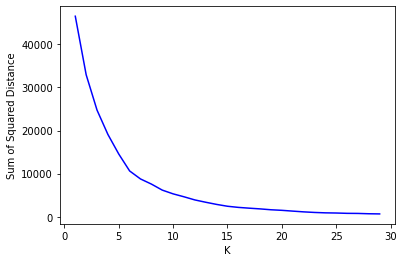

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 5000)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

### Silhouette Method

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df.iloc[:,:-1])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.iloc[:, :-2], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.iloc[:, :-3], df['cluster'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220805_1655]NOTED k = 15일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.334
군집 별 실루엣 계수 평균: 
cluster
0    0.448301
1    0.291756
Name: sil_sam, dtype: float64
score: 0.078
---------------
전체 실루엣 계수 평균: 0.363
군집 별 실루엣 계수 평균: 
cluster
0    0.399130
1    0.393298
2    0.312654
Name: sil_sam, dtype: float64
score: 0.039
---------------
전체 실루엣 계수 평균: 0.441
군집 별 실루엣 계수 평균: 
cluster
0    0.386509
1    0.629656
2    0.371025
3    0.433890
Name: sil_sam, dtype: float64
score: 0.080
---------------
전체 실루엣 계수 평균: 0.508
군집 별 실루엣 계수 평균: 
cluster
0    0.831944
1    0.310265
2    0.456252
3    0.566345
4    0.662672
Name: sil_sam, dtype: float64
score: 0.157
---------------
전체 실루엣 계수 평균: 0.575
군집 별 실루엣 계수 평균: 
cluster
0    0.632866
1    0.823322
2    0.646311
3    0.300283
4    0.566345
5    0.533343
Name: sil_sam, dtype: float64
score: 0.117
---------------
전체 실루엣 계수 평균: 0.614
군집 별 실루엣 계수 평균: 
cluster
0    0.648648
1    0.459614
2    0.573252
3    0.566345
4    0.823788
5    0.819158
6    0.403292
Name: sil_sam, dtype: float64
score: 0.129
--------------

In [8]:
df.drop('cluster', axis = 1, inplace = True)
df

KeyError: "['cluster'] not found in axis"

In [10]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,4,2,11,16,3,6,12,6,11,1,...,13,9,13,10,9,3,15,8,0.847826,2
1,5,3,13,11,3,7,12,5,12,3,...,7,5,12,7,12,3,16,15,0.847826,4
2,4,3,12,11,4,6,11,6,12,1,...,11,8,14,14,9,3,17,3,0.934783,2
3,5,3,12,13,3,7,11,5,11,2,...,8,5,12,7,12,3,16,15,0.847826,4
4,6,2,6,18,2,7,13,8,5,0,...,11,2,11,12,15,8,12,15,0.434783,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,2,13,15,4,9,12,8,10,1,...,10,2,10,10,11,7,8,19,0.369565,3
140,6,2,13,15,4,9,12,8,10,1,...,10,2,10,10,11,7,8,19,0.369565,3
141,5,2,10,12,2,7,16,3,8,1,...,9,4,7,11,15,7,11,17,0.500000,6
142,5,2,10,12,2,7,16,3,8,1,...,9,4,7,11,15,7,11,17,0.500000,6


## K-means 모델 생성

## DBSCAN 모델 생성

In [27]:
df.drop('cluster', axis = 1, inplace = True)

In [28]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,pca_x,pca_y
0,4,2,11,16,3,6,12,6,11,1,...,13,10,9,3,15,8,0.847826,2,10.016114,10.485593
1,5,3,13,11,3,7,12,5,12,3,...,12,7,12,3,16,15,0.847826,4,18.695194,-4.823261
2,4,3,12,11,4,6,11,6,12,1,...,14,14,9,3,17,3,0.934783,2,11.561707,12.430253
3,5,3,12,13,3,7,11,5,11,2,...,12,7,12,3,16,15,0.847826,4,17.426735,-5.038694
4,6,2,6,18,2,7,13,8,5,0,...,11,12,15,8,12,15,0.434783,7,-8.799053,-3.506081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,2,13,15,4,9,12,8,10,1,...,10,10,11,7,8,19,0.369565,3,1.390507,-1.716018
140,6,2,13,15,4,9,12,8,10,1,...,10,10,11,7,8,19,0.369565,3,1.390507,-1.716018
141,5,2,10,12,2,7,16,3,8,1,...,7,11,15,7,11,17,0.500000,6,0.039876,-6.794885
142,5,2,10,12,2,7,16,3,8,1,...,7,11,15,7,11,17,0.500000,6,0.039876,-6.794885


### DBSCAN

In [9]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.9, min_samples = 4, metric = 'euclidean')
dbscan_labels = dbscan.fit_predict(df.iloc[:,:-3])
df['dbscan_cluster'] = dbscan_labels

df.groupby(['dbscan_cluster'])['target'].value_counts()

dbscan_cluster  target
-1              4         23
                0         17
                8         17
                2         10
                5          9
                3          4
                6          4
                1          3
                7          3
 0              7          8
 1              8          5
 2              8          8
 3              4          6
 4              7          4
 5              0          4
 6              6         14
 7              6          5
Name: target, dtype: int64

## K-means

In [9]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5, max_iter = 10000)
kmeans.fit(df.loc[:,:'GC-contents'])
print(cal_accuracy(df['target'], kmeans.labels_))
#[220806_1133]NOTED 정확도: 94%, 97%

0.9591315453384419


In [14]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index], data.iloc[start_index + len(df.index) // cv:]]), data.iloc[start_index:start_index + len(df.index) // cv]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.952, 0.963, 0.9683, 0.969, 0.9332]
평균 검증 정확도: 0.9571


In [15]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,4,2,11,16,3,6,12,6,11,1,...,13,9,13,10,9,3,15,8,0.847826,2
1,5,3,13,11,3,7,12,5,12,3,...,7,5,12,7,12,3,16,15,0.847826,4
2,4,3,12,11,4,6,11,6,12,1,...,11,8,14,14,9,3,17,3,0.934783,2
3,5,3,12,13,3,7,11,5,11,2,...,8,5,12,7,12,3,16,15,0.847826,4
4,6,2,6,18,2,7,13,8,5,0,...,11,2,11,12,15,8,12,15,0.434783,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,2,13,15,4,9,12,8,10,1,...,10,2,10,10,11,7,8,19,0.369565,3
140,6,2,13,15,4,9,12,8,10,1,...,10,2,10,10,11,7,8,19,0.369565,3
141,5,2,10,12,2,7,16,3,8,1,...,9,4,7,11,15,7,11,17,0.500000,6
142,5,2,10,12,2,7,16,3,8,1,...,9,4,7,11,15,7,11,17,0.500000,6


In [26]:
df['cluster'] = kmeans.labels_

## 평균 이동

In [16]:
from sklearn.cluster import MeanShift, estimate_bandwidth

meanshift = MeanShift(bandwidth = 19)
df['meanshift_cluster']= meanshift.fit_predict(df.iloc[:,:-2])
df.groupby(['target', 'meanshift_cluster'])['AAA'].count()
print(estimate_bandwidth(df.iloc[:,:-2]))

23.18187480632099


## 데이터 시각화

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df.loc[:, :'GC-contents'])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,pca_x,pca_y
0,4,2,11,16,3,6,12,6,11,1,...,13,10,9,3,15,8,0.847826,2,10.016114,10.485593
1,5,3,13,11,3,7,12,5,12,3,...,12,7,12,3,16,15,0.847826,4,18.695194,-4.823261
2,4,3,12,11,4,6,11,6,12,1,...,14,14,9,3,17,3,0.934783,2,11.561707,12.430253
3,5,3,12,13,3,7,11,5,11,2,...,12,7,12,3,16,15,0.847826,4,17.426735,-5.038694
4,6,2,6,18,2,7,13,8,5,0,...,11,12,15,8,12,15,0.434783,7,-8.799053,-3.506081


### 타겟 분포

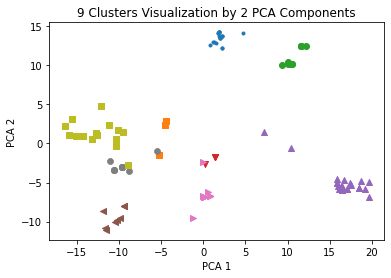

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

### 클러스터 분포

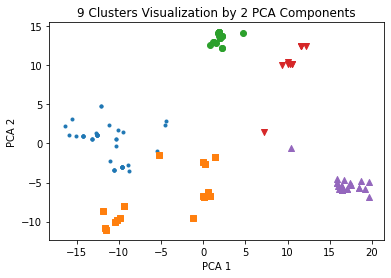

In [27]:
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

In [28]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4
target,,,,,
0,0,0,21,0,0
1,2,1,0,0,0
2,0,0,0,10,0
3,0,4,0,0,0
4,0,0,0,1,28
5,0,9,0,0,0
6,0,23,0,0,0
7,15,0,0,0,0
8,30,0,0,0,0
